# Connect-4 ENV reward hyperparameter sweep (fast bitboard)

Notebook sweeps **reward-shaping hyperparameters** for  `Connect4Env`-style reward function using a **bitboard-only** match loop, then  runs a **round-robin** among the top configs and exports everything to a single Excel workbook.


In [1]:
import os
import time
import math
import itertools
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from numba import njit, uint64, int32

from openpyxl.styles import Font, Alignment, PatternFill
from openpyxl.utils import get_column_letter
from openpyxl.formatting.rule import ColorScaleRule

from C4.fast_connect4_lookahead import Connect4Lookahead
from C4.eval_oppo_dict import EVAL_CFG, EVALUATION_OPPONENTS, OPENING_NOISE_K


In [2]:
# Default reward hyperparameters (baseline)
ENV_DEFAULTS = {
    "THREAT2_VALUE": 2.0,
    "THREAT3_VALUE": 10.0,
    "BLOCK2_VALUE": 2.5,
    "BLOCK3_VALUE": 15.0,

    "MAX_REWARD": 999.0,
    "WIN_REWARD": 10000.0,
    "DRAW_REWARD": 20.0,
    "LOSS_PENALTY": -10000.0,

    "CENTER_REWARD": 1.0,
    "CENTER_REWARD_BOTTOM": 999.0,
    "FORK_BONUS": 20.0,
    "BLOCK_FORK_BONUS": 25.0,
    "OPP_IMMEDIATE_PENALTY": 100.0,
    "STEP_PENALTY": 1.0,

    "CENTER_WEIGHTS": [0.90, 0.85, 0.95, 1.00, 0.95, 0.85, 0.90],
    "OPENING_DECAY_STEPS": 7,
}

ENV_DEFAULTS


{'THREAT2_VALUE': 2.0,
 'THREAT3_VALUE': 10.0,
 'BLOCK2_VALUE': 2.5,
 'BLOCK3_VALUE': 15.0,
 'MAX_REWARD': 999.0,
 'WIN_REWARD': 10000.0,
 'DRAW_REWARD': 20.0,
 'LOSS_PENALTY': -10000.0,
 'CENTER_REWARD': 1.0,
 'CENTER_REWARD_BOTTOM': 999.0,
 'FORK_BONUS': 20.0,
 'BLOCK_FORK_BONUS': 25.0,
 'OPP_IMMEDIATE_PENALTY': 100.0,
 'STEP_PENALTY': 1.0,
 'CENTER_WEIGHTS': [0.9, 0.85, 0.95, 1.0, 0.95, 0.85, 0.9],
 'OPENING_DECAY_STEPS': 7}

In [3]:
# ------------------------- Reward search space -------------------------

SEARCH_SPACE: Dict[str, List[object]] = {
    # threats / blocks
    "THREAT2_VALUE": [5],
    "THREAT3_VALUE": [10],

    "BLOCK2_VALUE":  [5],
    "BLOCK3_VALUE":  [20],

    # terminal & bounds
    "MAX_REWARD":    [999.0],
    "WIN_REWARD":    [10000.0],
    "DRAW_REWARD":   [100],

    # position shaping
    "CENTER_REWARD": [0.1],
    "CENTER_REWARD_BOTTOM": [999.0],
    "OPENING_DECAY_STEPS":  [10],

    # forks / punishments / step cost
    "FORK_BONUS":           [25],
    "BLOCK_FORK_BONUS":     [25],
    "OPP_IMMEDIATE_PENALTY":[1000],
    "STEP_PENALTY":         [1.0],


    "CENTER_WEIGHTS": [
        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    ],
}


In [4]:
# ------------------------------- Settings --------------------------------

SEED = 666
rng = np.random.default_rng(SEED)

# Reward-search agent depth (your "policy" depth during evaluation matches)
REWARD_AGENT_DEPTH = 3  # depth=3 can be heavy, but this notebook is optimized for it

# How many configs to keep in a top-K round robin
TOPK_ROUND_ROBIN = 8
GAMES_PER_PAIR = 30  # each pair plays 2*GAMES_PER_PAIR games (alternating start)

# Export
EXPORT = True
OUT_DIR = "env_reward_sweep_out"
OUT_XLSX = os.path.join(OUT_DIR, "env_reward_sweep.xlsx")

In [5]:

def merge_cfg(override: Dict[str, object]) -> Dict[str, object]:
    """Merge ENV_DEFAULTS with override + derived fields (LOSS_PENALTY, CENTER_REWARD_BOTTOM)."""
    cfg = dict(ENV_DEFAULTS)
    cfg.update(override)

    # derived knobs you said you "lost" after rearranging:
    # - LOSS_PENALTY tracks WIN_REWARD unless explicitly overridden
    if "LOSS_PENALTY" in override:
        cfg["LOSS_PENALTY"] = float(override["LOSS_PENALTY"])
    else:
        cfg["LOSS_PENALTY"] = -float(cfg["WIN_REWARD"])

    # CENTER_REWARD_BOTTOM defaults to MAX_REWARD unless overridden
    if "CENTER_REWARD_BOTTOM" in override:
        cfg["CENTER_REWARD_BOTTOM"] = float(override["CENTER_REWARD_BOTTOM"])
    else:
        cfg["CENTER_REWARD_BOTTOM"] = float(cfg["MAX_REWARD"])

    # basic sanity
    cw = cfg.get("CENTER_WEIGHTS", None)
    if not (isinstance(cw, (list, tuple)) and len(cw) == 7):
        raise ValueError(f"CENTER_WEIGHTS must be list of length 7, got: {cw}")

    return cfg

def make_candidates(search_space: Dict[str, List[object]]) -> List[Dict[str, object]]:
    keys = list(search_space.keys())
    values = [search_space[k] for k in keys]
    out: List[Dict[str, object]] = []
    for combo in itertools.product(*values):
        override = dict(zip(keys, combo))
        out.append(merge_cfg(override))
    return out

candidates = make_candidates(SEARCH_SPACE)
print("Candidates:", len(candidates))

Candidates: 4


In [6]:
# ----------------------------- Bitboard core -----------------------------

ROWS, COLS, K = 6, 7, 4
STRIDE = ROWS + 1  # Pascal Pons layout stride (7)
CENTER_COL = 3

UINT = np.uint64
COL_MASK    = np.zeros(COLS, dtype=UINT)
TOP_MASK    = np.zeros(COLS, dtype=UINT)
BOTTOM_MASK = np.zeros(COLS, dtype=UINT)
FULL_MASK   = UINT(0)

for c in range(COLS):
    col_bits = UINT(0)
    for r in range(ROWS):
        col_bits |= UINT(1) << UINT(c * STRIDE + r)
    COL_MASK[c] = col_bits
    BOTTOM_MASK[c] = UINT(1) << UINT(c * STRIDE + 0)
    TOP_MASK[c] = UINT(1) << UINT(c * STRIDE + (ROWS - 1))
    FULL_MASK |= col_bits

CENTER_ORDER = (3, 4, 2, 5, 1, 6, 0)

@njit(cache=True, fastmath=True)
def bb_has_won(bb: uint64, stride_i: int32) -> bool:
    m = bb & (bb >> uint64(1))                     # vertical
    if (m & (m >> uint64(2))) != uint64(0): return True
    m = bb & (bb >> uint64(stride_i))              # horizontal
    if (m & (m >> uint64(2 * stride_i))) != uint64(0): return True
    m = bb & (bb >> uint64(stride_i + 1))          # diag up-right
    if (m & (m >> uint64(2 * (stride_i + 1)))) != uint64(0): return True
    m = bb & (bb >> uint64(stride_i - 1))          # diag up-left
    if (m & (m >> uint64(2 * (stride_i - 1)))) != uint64(0): return True
    return False

def can_play(mask: int, c: int) -> bool:
    return (mask & int(TOP_MASK[c])) == 0

def play_bit(mask: int, c: int) -> int:
    # (mask + bottom) & colmask trick
    return int((UINT(mask) + BOTTOM_MASK[c]) & COL_MASK[c])

# Precompute 69 windows (bit masks)
WIN_MASKS: List[int] = []
# horizontal
for r in range(ROWS):
    for c in range(COLS - K + 1):
        m = 0
        for i in range(K):
            m |= 1 << ( (c + i) * STRIDE + r )
        WIN_MASKS.append(m)
# vertical
for c in range(COLS):
    for r in range(ROWS - K + 1):
        m = 0
        for i in range(K):
            m |= 1 << ( c * STRIDE + (r + i) )
        WIN_MASKS.append(m)
# diag up-right
for r in range(ROWS - K + 1):
    for c in range(COLS - K + 1):
        m = 0
        for i in range(K):
            m |= 1 << ( (c + i) * STRIDE + (r + i) )
        WIN_MASKS.append(m)
# diag up-left
for r in range(ROWS - K + 1):
    for c in range(K - 1, COLS):
        m = 0
        for i in range(K):
            m |= 1 << ( (c - i) * STRIDE + (r + i) )
        WIN_MASKS.append(m)

assert len(WIN_MASKS) == 69

def count_pure(pos_me: int, pos_opp: int, n: int) -> int:
    cnt = 0
    for w in WIN_MASKS:
        mo = w & pos_opp
        if mo != 0:
            continue
        mp = w & pos_me
        if mp.bit_count() == n:
            cnt += 1
    return cnt

def count_immediate_wins(pos_me: int, mask: int) -> int:
    cnt = 0
    for c in CENTER_ORDER:
        if not can_play(mask, c):
            continue
        mv = play_bit(mask, c)
        nm = mask | mv
        me2 = pos_me | mv
        if bb_has_won(uint64(me2), int32(STRIDE)):
            cnt += 1
    return cnt


In [7]:
# -------------------------- Reward evaluator (BB) --------------------------

class RewardEvaluatorBB:
    """Fast reward computation using only bitboards + cached feature counts."""

    def __init__(self, cfg: Dict[str, object]):
        self.cfg = cfg

        # required keys (float)
        self.THREAT2_VALUE = float(cfg["THREAT2_VALUE"])
        self.THREAT3_VALUE = float(cfg["THREAT3_VALUE"])
        self.BLOCK2_VALUE  = float(cfg["BLOCK2_VALUE"])
        self.BLOCK3_VALUE  = float(cfg["BLOCK3_VALUE"])

        self.MAX_REWARD = float(cfg["MAX_REWARD"])
        self.WIN_REWARD = float(cfg["WIN_REWARD"])
        self.DRAW_REWARD = float(cfg["DRAW_REWARD"])
        self.LOSS_PENALTY = float(cfg["LOSS_PENALTY"])

        self.CENTER_REWARD = float(cfg["CENTER_REWARD"])
        self.CENTER_REWARD_BOTTOM = float(cfg["CENTER_REWARD_BOTTOM"])
        self.OPENING_DECAY_STEPS = int(cfg["OPENING_DECAY_STEPS"])

        self.FORK_BONUS = float(cfg["FORK_BONUS"])
        self.BLOCK_FORK_BONUS = float(cfg["BLOCK_FORK_BONUS"])
        self.OPP_IMMEDIATE_PENALTY = float(cfg["OPP_IMMEDIATE_PENALTY"])
        self.STEP_PENALTY = float(cfg["STEP_PENALTY"])

        cw = np.asarray(cfg["CENTER_WEIGHTS"], dtype=np.float32)
        self.CENTER_WEIGHTS = cw

        # feature caches (keyed by (pos,opp))
        self._pure_cache: Dict[Tuple[int,int], Tuple[int,int]] = {}
        self._imm_cache: Dict[Tuple[int,int], int] = {}

    def pure23(self, pos_me: int, pos_opp: int) -> Tuple[int,int]:
        k = (pos_me, pos_opp)
        v = self._pure_cache.get(k, None)
        if v is not None:
            return v
        v = (count_pure(pos_me, pos_opp, 2), count_pure(pos_me, pos_opp, 3))
        self._pure_cache[k] = v
        return v

    def imm(self, pos_me: int, mask: int) -> int:
        k = (pos_me, mask)
        v = self._imm_cache.get(k, None)
        if v is not None:
            return v
        v = count_immediate_wins(pos_me, mask)
        self._imm_cache[k] = v
        return v

    def terminal_reward(self, winner: int, mover: int) -> float:
        # winner: +1 (P1), -1 (P2), 0 (draw)
        if winner == mover:
            return self.WIN_REWARD
        if winner == 0:
            return self.DRAW_REWARD
        return self.LOSS_PENALTY

    def shaping_reward(
        self,
        pos_before_me: int,
        pos_before_opp: int,
        mask_before: int,
        pos_after_me: int,
        pos_after_opp: int,
        mask_after: int,
        col: int,
        r_bot: int,
        ply_before: int,
    ) -> float:
        # threats
        t2, t3 = self.pure23(pos_after_me, pos_after_opp)

        # blocks = delta of opponent's pure windows removed by the move
        opp_t2_before, opp_t3_before = self.pure23(pos_before_opp, pos_before_me)
        opp_t2_after,  opp_t3_after  = self.pure23(pos_after_opp, pos_after_me)
        b2 = max(0, opp_t2_before - opp_t2_after)
        b3 = max(0, opp_t3_before - opp_t3_after)

        threat_reward = self.THREAT2_VALUE * t2 + self.THREAT3_VALUE * t3
        block_reward  = self.BLOCK2_VALUE  * b2 + self.BLOCK3_VALUE  * b3

        # center shaping
        center_reward = self.CENTER_REWARD * float(self.CENTER_WEIGHTS[col])

        if col == CENTER_COL and r_bot == 0:
            opening_decay = math.exp(-ply_before / float(self.OPENING_DECAY_STEPS))
            bonus = self.CENTER_REWARD_BOTTOM * (2.0 if ply_before == 0 else opening_decay)
            center_reward += bonus

        # fork / anti-fork shaping via immediate wins signals
        my_after = self.imm(pos_after_me, mask_after)
        opp_before = self.imm(pos_before_opp, mask_before)
        opp_after  = self.imm(pos_after_opp, mask_after)

        fork_bonus = self.FORK_BONUS if my_after >= 2 else 0.0
        blocked_fork = (opp_before >= 2) and (opp_after < opp_before)
        block_fork_bonus = self.BLOCK_FORK_BONUS if blocked_fork else 0.0

        immediate_loss_penalty = self.OPP_IMMEDIATE_PENALTY * float(opp_after)

        reward = threat_reward + block_reward + fork_bonus + block_fork_bonus + center_reward - immediate_loss_penalty
        reward = float(np.clip(reward, -self.MAX_REWARD, self.MAX_REWARD))
        reward -= self.STEP_PENALTY
        return float(reward)


In [8]:
# -------------------------- Reward search agent --------------------------

@dataclass
class BBState:
    # current mover is implicit in whose 'pos' we store as `pos_me` below
    pos_me: int
    pos_opp: int
    mask: int
    heights: Tuple[int, ...]  # length 7, bottom-based heights [0..6]
    ply: int

def apply_move_bb(st: BBState, col: int) -> Tuple[BBState, int]:
    """Apply move for current mover. Returns (new_state_for_opponent, r_bot)."""
    h = st.heights[col]
    mv = play_bit(st.mask, col)
    nm = st.mask | mv
    me2 = st.pos_me | mv
    opp2 = st.pos_opp

    # update heights
    heights2 = list(st.heights)
    heights2[col] = h + 1

    # switch mover: new state's pos_me is previous opp
    return BBState(
        pos_me=opp2,
        pos_opp=me2,
        mask=nm,
        heights=tuple(heights2),
        ply=st.ply + 1,
    ), int(h)

def winner_after_move(pos_me_after: int, mask_after: int) -> Optional[int]:
    # winner is player who just moved => represented by `pos_me_after` in the *before* frame.
    # Here we only need to detect if the last mover won (pos_me_after has that player's stones).
    if bb_has_won(uint64(pos_me_after), int32(STRIDE)):
        return 1  # caller will map to mover sign
    if mask_after == int(FULL_MASK):
        return 0
    return None

class RewardSearchAgent:
    def __init__(self, cfg: Dict[str, object], evaluator: RewardEvaluatorBB, depth: int = 3, opening_noise_k: Dict[int,float] = None, name: str = "CFG"):
        self.cfg = cfg
        self.E = evaluator
        self.depth = int(depth)
        self.opening_noise_k = dict(opening_noise_k or {})
        self.name = name

        # Persistent TT to speed repeated calls (key=(pos_me,pos_opp,mask,depth) in current mover POV)
        self.tt: Dict[Tuple[int,int,int,int], float] = {}

    def _legal_cols(self, st: BBState) -> List[int]:
        return [c for c in range(COLS) if st.heights[c] < ROWS]

    def _negamax(self, st: BBState, depth: int, alpha: float, beta: float) -> float:
        key = (st.pos_me, st.pos_opp, st.mask, depth)
        v = self.tt.get(key, None)
        if v is not None:
            return v

        legal = self._legal_cols(st)
        if not legal:
            return 0.0

        # terminal already?
        if bb_has_won(uint64(st.pos_opp), int32(STRIDE)):
            # opponent (previous mover) has already won => bad for current mover
            v = self.E.LOSS_PENALTY
            self.tt[key] = v
            return v
        if st.mask == int(FULL_MASK):
            v = self.E.DRAW_REWARD
            self.tt[key] = v
            return v

        if depth == 0:
            # Heuristic: evaluate as 0 (we're only comparing configs via gameplay),
            # but you can swap this for a cheap board heuristic if you want.
            return 0.0

        best = -1e18
        # center-first ordering
        for col in CENTER_ORDER:
            if col not in legal:
                continue

            st2, r_bot = apply_move_bb(st, col)

            # last mover was st.pos_me in the pre-move frame
            mover_pos_after = st.pos_opp  # careful: after apply_move, st2.pos_opp == me2
            mover_pos_after = st2.pos_opp
            winner = None
            if bb_has_won(uint64(mover_pos_after), int32(STRIDE)):
                winner = 1
            elif st2.mask == int(FULL_MASK):
                winner = 0

            if winner is not None:
                # terminal reward for mover (current player before move)
                r = self.E.terminal_reward(winner=(+1 if winner==1 else 0), mover=+1)
                val = r
            else:
                r = self.E.shaping_reward(
                    pos_before_me=st.pos_me,
                    pos_before_opp=st.pos_opp,
                    mask_before=st.mask,
                    pos_after_me=st2.pos_opp,   # mover stones after
                    pos_after_opp=st2.pos_me,   # opponent stones after
                    mask_after=st2.mask,
                    col=col,
                    r_bot=r_bot,
                    ply_before=st.ply,
                )
                val = r - self._negamax(st2, depth-1, -beta, -alpha)

            if val > best:
                best = val
            if best > alpha:
                alpha = best
            if alpha >= beta:
                break

        self.tt[key] = best
        return best

    def act(self, st, rng: np.random.Generator) -> int:
        """Standard interface: choose action from a GameState-like object."""
        heights = tuple(int(x) for x in np.asarray(st.heights).tolist())
        return self._act_bb(
            pos1=int(st.pos1),
            pos2=int(st.pos2),
            mask=int(st.mask),
            heights=heights,
            ply=int(st.ply),
            mover=int(st.mover),
            rng=rng,
        )


    def _act_bb(self, pos1: int, pos2: int, mask: int, heights: Tuple[int, ...], ply: int, mover: int, rng: np.random.Generator) -> int:
        """Return action for mover (+1 or -1)."""
        # Opening noise: occasionally choose random among top-k actions on early plies
        noise_k = float(self.opening_noise_k.get(ply, 0.0))
        legal = [c for c in range(COLS) if heights[c] < ROWS]
        if not legal:
            return 0

        # Represent state in mover POV
        me = pos1 if mover == 1 else pos2
        opp = pos2 if mover == 1 else pos1
        st = BBState(pos_me=int(me), pos_opp=int(opp), mask=int(mask), heights=heights, ply=int(ply))

        # Score all legal moves
        scored = []
        for col in CENTER_ORDER:
            if col not in legal:
                continue
            st2, r_bot = apply_move_bb(st, col)

            mover_pos_after = st2.pos_opp
            winner = None
            if bb_has_won(uint64(mover_pos_after), int32(STRIDE)):
                winner = 1
            elif st2.mask == int(FULL_MASK):
                winner = 0

            if winner is not None:
                r = self.E.WIN_REWARD if winner == 1 else self.E.DRAW_REWARD
                v = r
            else:
                r = self.E.shaping_reward(
                    pos_before_me=st.pos_me,
                    pos_before_opp=st.pos_opp,
                    mask_before=st.mask,
                    pos_after_me=st2.pos_opp,
                    pos_after_opp=st2.pos_me,
                    mask_after=st2.mask,
                    col=col,
                    r_bot=r_bot,
                    ply_before=st.ply,
                )
                v = r - self._negamax(st2, self.depth-1, -1e18, 1e18)
            scored.append((v, col))

        scored.sort(reverse=True, key=lambda x: x[0])
        best_col = scored[0][1]

        if noise_k > 0.0 and len(scored) > 1 and rng.random() < noise_k:
            k = min(3, len(scored))
            return int(rng.choice([c for _, c in scored[:k]]))

        return int(best_col)


In [9]:
# ------------------------ Match / evaluation utilities ------------------------

@dataclass
class GameState:
    board: np.ndarray        # (6,7) top-first, values in {0, +1, -1}
    pos1: int
    pos2: int
    mask: int
    heights: np.ndarray      # (7,) int8
    mover: int               # +1 or -1
    ply: int

def new_game() -> GameState:
    return GameState(
        board=np.zeros((ROWS, COLS), dtype=np.int8),
        pos1=0,
        pos2=0,
        mask=0,
        heights=np.zeros(COLS, dtype=np.int8),
        mover=1,
        ply=0,
    )

def apply_move_game(st: GameState, col: int) -> Tuple[Optional[int], int]:
    """Apply a move in-place. Returns (winner: +1/-1/0/None, r_bot)."""
    r_bot = int(st.heights[col])
    mv = play_bit(st.mask, col)
    st.mask |= mv
    if st.mover == 1:
        st.pos1 |= mv
        me_bb = st.pos1
    else:
        st.pos2 |= mv
        me_bb = st.pos2

    st.heights[col] = r_bot + 1

    # update 2D board (top-first)
    placed_row = ROWS - 1 - r_bot
    st.board[placed_row, col] = st.mover

    # terminal?
    if bb_has_won(uint64(me_bb), int32(STRIDE)):
        return st.mover, r_bot
    if st.mask == int(FULL_MASK):
        return 0, r_bot
    return None, r_bot

def legal_cols_from_heights(heights: np.ndarray) -> List[int]:
    return [c for c in range(COLS) if heights[c] < ROWS]

# Opponent factories
LA = Connect4Lookahead()

class RandomAgent:
    name = "Random"
    def act(self, st: GameState, rng: np.random.Generator) -> int:
        legal = legal_cols_from_heights(st.heights)
        return int(rng.choice(legal)) if legal else 0

class LeftmostAgent:
    name = "Leftmost"
    def act(self, st: GameState, rng: np.random.Generator) -> int:
        legal = legal_cols_from_heights(st.heights)
        return int(min(legal)) if legal else 0

class CenterAgent:
    name = "Center"
    def act(self, st: GameState, rng: np.random.Generator) -> int:
        for c in CENTER_ORDER:
            if st.heights[c] < ROWS:
                return int(c)
        return 0

class LookaheadAgent:
    def __init__(self, depth: int):
        self.depth = int(depth)
        self.name = f"Lookahead-{self.depth}"
    def act(self, st: GameState, rng: np.random.Generator) -> int:
        # LA expects board with players in {0,1,2} or {0,1,-1}; we provide {0,1,-1}
        return int(LA.n_step_lookahead(st.board, st.mover, depth=self.depth))

def play_game(agentA, agentB, start_player: int, rng: np.random.Generator) -> int:
    """Return winner: 1 if agentA wins, 2 if agentB wins, 0 if draw."""
    st = new_game()
    st.mover = 1
    # assign which agent plays as +1/-1
    if start_player == 1:
        p1_agent, p2_agent = agentA, agentB
    else:
        p1_agent, p2_agent = agentB, agentA

    while True:
        # pick action (all agents expose .act(st, rng))
        if st.mover == 1:
            col = p1_agent.act(st, rng)
        else:
            col = p2_agent.act(st, rng)

        if st.heights[col] >= ROWS:
            # illegal move => immediate loss for mover
            winner = -st.mover
            break

        winner, _ = apply_move_game(st, col)
        if winner is not None:
            break

        st.mover *= -1
        st.ply += 1

    # map winner (+1/-1/0) to A/B
    if winner == 0:
        return 0
    if start_player == 1:
        # A is +1
        return 1 if winner == 1 else 2
    else:
        # A is -1
        return 1 if winner == -1 else 2

def eval_vs_opponents(agent: RewardSearchAgent, eval_cfg: Dict[str,int], rng: np.random.Generator) -> Dict[str, float]:
    """Returns points-per-game vs each opponent key."""
    out = {}
    for opp_name, games in eval_cfg.items():
        if opp_name == "Random":
            opp = RandomAgent()
        elif opp_name == "Leftmost":
            opp = LeftmostAgent()
        elif opp_name == "Center":
            opp = CenterAgent()
        elif opp_name.startswith("Lookahead-"):
            d = int(opp_name.split("-")[1])
            opp = LookaheadAgent(d)
        else:
            raise ValueError(f"Unknown opponent {opp_name}")

        pts = 0.0
        total = 0
        for g in range(games):
            # game 1: agent starts
            w = play_game(agent, opp, start_player=1, rng=rng)
            total += 1
            pts += 1.0 if w == 1 else (0.5 if w == 0 else 0.0)

            # game 2: opponent starts
            w = play_game(agent, opp, start_player=2, rng=rng)
            total += 1
            pts += 1.0 if w == 1 else (0.5 if w == 0 else 0.0)

        out[opp_name] = pts / total if total else 0.0
    return out


In [10]:
%%time
# ----------------------------- Sweep candidates -----------------------------

import re
import time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

def opponent_weight(label: str,
                    base: float = 1.4,
                    random_weight: float = 1.0,
                    default_weight: float = 1.0) -> float:
    s = str(label)

    if "Random" in s:
        return float(random_weight)

    m = re.search(r"(\d+)", s)
    if m:
        depth = int(m.group(1))
        return float(base) ** depth

    return float(default_weight)

def global_score_from_scores(scores: dict,
                            base: float = 1.4,
                            use_ppg: bool = True) -> float:
    """
    scores: dict label -> PPG (0..1) from eval_vs_opponents()

    If you later change eval_vs_opponents to return win_rate instead of PPG,
    this still works because both are in [0,1]. (PPG includes draws.)
    """
    num = 0.0
    den = 0.0
    for label, v in scores.items():
        val = float(v)
        w = opponent_weight(label, base=base)
        num += w * val
        den += w
    return num / den if den > 1e-12 else float("nan")


# tweakable: higher base => much stronger preference for deep lookahead
GLOBAL_BASE = 1.4

rows_meta = []
rows_detail = []

t0 = time.time()

for idx, cfg in enumerate(tqdm(candidates, desc="Candidates")):
    E = RewardEvaluatorBB(cfg)
    agent = RewardSearchAgent(
        cfg=cfg,
        evaluator=E,
        depth=REWARD_AGENT_DEPTH,
        opening_noise_k=OPENING_NOISE_K,
        name=f"CFG_{idx:04d}",
    )

    scores = eval_vs_opponents(agent, EVAL_CFG, rng=rng)  # label -> PPG in [0,1]

    # Legacy metascore (unweighted sum of PPGs)
    metascore = float(sum(float(v) for v in scores.values()))

    # New global score (depth-weighted mean)
    global_score = float(global_score_from_scores(scores, base=GLOBAL_BASE))

    rows_meta.append({
        "name": agent.name,
        "global_score": global_score,
        "metascore": metascore,
        **{k: float(scores[k]) for k in scores},
    })

    # config detail row (preserve your column naming)
    row_cfg = {"name": agent.name, **{k: cfg[k] for k in ENV_DEFAULTS.keys()}}
    rows_detail.append(row_cfg)

dt = time.time() - t0

df_meta = (
    pd.DataFrame(rows_meta)
      .sort_values(["global_score", "metascore"], ascending=False)
      .reset_index(drop=True)
)
df_detail = pd.DataFrame(rows_detail)

print(f"Done sweep: candidates={len(candidates)}, elapsed={dt:.1f}s")
df_meta.head(10)


Candidates:   0%|          | 0/4 [00:00<?, ?it/s]

Done sweep: candidates=4, elapsed=137.4s
CPU times: total: 2min 14s
Wall time: 2min 17s


,name,global_score,metascore,Random,Lookahead-1,Lookahead-2,Lookahead-3,Lookahead-4,Lookahead-5,Lookahead-6,Lookahead-7
0,CFG_0000,0.679348,6.422500,0.9975,1.000,0.95,0.950000,0.9,0.500,0.5,0.625
1,CFG_0003,0.528771,5.700000,1.0000,1.000,0.90,1.000000,0.5,0.550,0.5,0.250
2,CFG_0001,0.476428,5.468333,1.0000,0.985,1.00,0.858333,0.5,0.500,0.5,0.125
3,CFG_0002,0.464487,5.350000,1.0000,1.000,1.00,0.750000,0.5,0.475,0.5,0.125


In [11]:
# Column order you want (matches your Excel / Connect4Env constants)
CFG_COLS = [
    "THREAT2_VALUE",
    "THREAT3_VALUE",
    "BLOCK2_VALUE",
    "BLOCK3_VALUE",
    "MAX_REWARD",
    "WIN_REWARD",
    "DRAW_REWARD",
    "LOSS_PENALTY",
    "CENTER_REWARD",
    "CENTER_REWARD_BOTTOM",
    "FORK_BONUS",
    "BLOCK_FORK_BONUS",
    "OPP_IMMEDIATE_PENALTY",
    "STEP_PENALTY",
    "CENTER_WEIGHTS",
    "OPENING_DECAY_STEPS",
]

df_cfg = df_detail.copy()

# In some variants LOSS_PENALTY is derived from WIN_REWARD, so make sure it exists
if "LOSS_PENALTY" not in df_cfg.columns and "WIN_REWARD" in df_cfg.columns:
    df_cfg["LOSS_PENALTY"] = -df_cfg["WIN_REWARD"]

# Merge metascore onto the config rows
df_cfg = df_cfg.merge(df_meta[["name", "metascore", "global_score"]], on="name", how="left")

# Make CENTER_WEIGHTS display nicely (list instead of numpy array / tuple)
if "CENTER_WEIGHTS" in df_cfg.columns:
    df_cfg["CENTER_WEIGHTS"] = df_cfg["CENTER_WEIGHTS"].apply(
        lambda x: list(x) if isinstance(x, (np.ndarray, tuple)) else x
    )

# Reorder + sort
cols = ["name", "metascore", "global_score"] + [c for c in CFG_COLS if c in df_cfg.columns]
df_cfg = df_cfg[cols].sort_values("global_score", ascending=False).reset_index(drop=True)

df_cfg


,name,metascore,global_score,THREAT2_VALUE,THREAT3_VALUE,BLOCK2_VALUE,BLOCK3_VALUE,MAX_REWARD,WIN_REWARD,DRAW_REWARD,LOSS_PENALTY,CENTER_REWARD,CENTER_REWARD_BOTTOM,FORK_BONUS,BLOCK_FORK_BONUS,OPP_IMMEDIATE_PENALTY,STEP_PENALTY,CENTER_WEIGHTS,OPENING_DECAY_STEPS
0,CFG_0000,6.422500,0.679348,5,10,5,20,999.0,10000.0,100,-10000.0,0.1,999.0,25,25,1000,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",10
1,CFG_0003,5.700000,0.528771,5,25,5,20,999.0,10000.0,100,-10000.0,0.1,999.0,25,25,1000,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",10
2,CFG_0001,5.468333,0.476428,5,15,5,20,999.0,10000.0,100,-10000.0,0.1,999.0,25,25,1000,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",10
3,CFG_0002,5.350000,0.464487,5,20,5,20,999.0,10000.0,100,-10000.0,0.1,999.0,25,25,1000,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",10


In [12]:
# ------------------------- Round-robin among top configs -------------------------

K = min(TOPK_ROUND_ROBIN, len(df_meta))
topk = df_meta.head(K).copy()

agents = []
names = []

for r in topk.itertuples(index=False):
    # recover cfg from df_detail for that name
    cfg_row = df_detail[df_detail["name"] == r.name].iloc[0].to_dict()
    cfg = {k: cfg_row[k] for k in (list(ENV_DEFAULTS.keys()) + ["LOSS_PENALTY", "CENTER_REWARD_BOTTOM"])}

    E = RewardEvaluatorBB(cfg)
    agents.append(RewardSearchAgent(cfg, E, depth=REWARD_AGENT_DEPTH, opening_noise_k=OPENING_NOISE_K, name=r.name))
    names.append(r.name)

def round_robin(agents, names, games_per_pair: int, rng: np.random.Generator):
    N = len(agents)
    P = np.full((N, N), np.nan, dtype=np.float64)
    results = []

    # diagonal neutral (for display); real P keeps NaN
    for i in range(N):
        P[i, i] = np.nan

    t0 = time.time()
    for i in tqdm(range(N), desc="Round-robin rows"):
        for j in range(i + 1, N):
            a, b = agents[i], agents[j]
            pts_i = pts_j = 0.0
            games = 0

            for g in range(games_per_pair):
                w = play_game(a, b, start_player=1, rng=rng)
                games += 1
                if w == 1: pts_i += 1.0
                elif w == 2: pts_j += 1.0
                else: pts_i += 0.5; pts_j += 0.5

                w = play_game(a, b, start_player=2, rng=rng)
                games += 1
                if w == 1: pts_i += 1.0
                elif w == 2: pts_j += 1.0
                else: pts_i += 0.5; pts_j += 0.5

            P[i, j] = pts_i / games
            P[j, i] = pts_j / games

            results.append({
                "i": i, "j": j,
                "name_i": names[i], "name_j": names[j],
                "points_i": pts_i, "points_j": pts_j,
                "games": games,
                "ppg_i": P[i, j], "ppg_j": P[j, i],
            })

    dt = time.time() - t0
    print(f"Done RR: N={N}, games per pair={2*games_per_pair}, elapsed={dt:.1f}s")

    return P, pd.DataFrame(results)

P, df_pairs = round_robin(agents, names, GAMES_PER_PAIR, rng=rng)

# display matrix with neutral diagonal
P_display = P.copy().astype(float)
np.fill_diagonal(P_display, 0.5)
df_ppg = pd.DataFrame(P_display, index=names, columns=names)
df_ppg


Round-robin rows:   0%|          | 0/4 [00:00<?, ?it/s]

Done RR: N=4, games per pair=60, elapsed=13.4s


,CFG_0000,CFG_0003,CFG_0001,CFG_0002
CFG_0000,0.500000,0.566667,0.425000,0.500000
CFG_0003,0.433333,0.500000,0.433333,0.516667
CFG_0001,0.575000,0.566667,0.500000,0.450000
CFG_0002,0.500000,0.483333,0.550000,0.500000


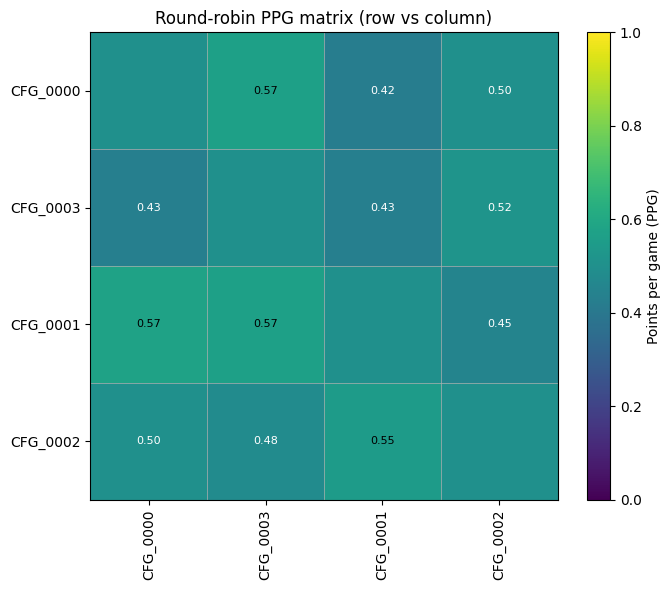

In [13]:
# ---------------- Heatmap of PPG matrix (readable diagonal + annotations) ----------------

M = df_ppg.to_numpy(dtype=np.float64, copy=True)
N = M.shape[0]  # <-- fixes the "N not defined" error

# Make diagonal blank for annotation, but keep 0.5 for colors
for i in range(N):
    M[i, i] = 0.5

M_masked = np.ma.masked_invalid(M)

fig, ax = plt.subplots(figsize=(max(8, 0.55*N), max(6, 0.55*N)))

cmap = plt.get_cmap().copy()
try:
    cmap.set_bad(color="white")
except Exception:
    pass
ax.set_facecolor("white")

im = ax.imshow(M_masked, vmin=0.0, vmax=1.0, interpolation="nearest", cmap=cmap)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Points per game (PPG)")

ax.set_xticks(np.arange(N))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(df_ppg.columns, rotation=90)
ax.set_yticklabels(df_ppg.index)
ax.set_title("Round-robin PPG matrix (row vs column)")

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

# Annotate (skip diagonal)
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        v = M[i, j]
        if np.isnan(v):
            continue
        color = "white" if v < 0.55 else "black"
        ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=8, color=color)

plt.tight_layout()
plt.show()

# Interpretation reminder:
# - Row agent i vs Column agent j = df_ppg.iloc[i, j] points-per-game for ROW agent.
# - Values > 0.50 => row agent tends to win that matchup.


In [14]:
# ----------------------------- Excel export -----------------------------

def write_df_sheet(writer: pd.ExcelWriter, df: pd.DataFrame, sheet: str):
    df.to_excel(writer, sheet_name=sheet, index=False)

def export_ppg_matrix_sheet(writer: pd.ExcelWriter, df_ppg: pd.DataFrame, sheet_name: str = "PPG", heatmap: bool = False):
    df = df_ppg.copy()

    # blank diagonal (display)
    n = min(df.shape[0], df.shape[1])
    for i in range(n):
        df.iat[i, i] = np.nan

    df.to_excel(writer, sheet_name=sheet_name, float_format="%.4f", na_rep="")
    ws = writer.sheets[sheet_name]

    FONT_BLACK = Font(color="FF000000")
    FONT_BLACK_BOLD = Font(bold=True, color="FF000000")
    center = Alignment(horizontal="center", vertical="center", wrap_text=True)

    fill_white = PatternFill(patternType="solid", fgColor="FFFFFFFF")
    fill_diag  = PatternFill(patternType="solid", fgColor="FFF2F2F2")

    # Header row
    for cell in ws[1]:
        cell.font = FONT_BLACK_BOLD
        cell.alignment = center
        cell.fill = fill_white

    # Index column
    for r in range(2, ws.max_row + 1):
        c0 = ws.cell(row=r, column=1)
        c0.font = FONT_BLACK_BOLD
        c0.alignment = center
        c0.fill = fill_white

    # Data region: FORCE white bg + black text
    for r in range(2, ws.max_row + 1):
        for c in range(2, ws.max_column + 1):
            cell = ws.cell(row=r, column=c)
            cell.font = FONT_BLACK
            cell.alignment = center
            cell.fill = fill_white
            cell.number_format = "0.0000"

    # Diagonal: blank + light gray
    for i in range(n):
        cell = ws.cell(row=2 + i, column=2 + i)
        cell.value = ""
        cell.fill = fill_diag
        cell.font = FONT_BLACK

    # Optional heatmap (kept OFF by default; if you enable it, it's still readable)
    if heatmap:
        data_range = f"{get_column_letter(2)}2:{get_column_letter(ws.max_column)}{ws.max_row}"
        ws.conditional_formatting.add(
            data_range,
            ColorScaleRule(
                start_type="num", start_value=0.0, start_color="FFF8696B",
                mid_type="num", mid_value=0.5, mid_color="FFFFFFFF",
                end_type="num", end_value=1.0, end_color="FF63BE7B",
            ),
        )

    ws.freeze_panes = "B2"
    ws.column_dimensions["A"].width = max(10, max(len(str(x)) for x in df.index) + 2)
    for j, col in enumerate(df.columns, start=2):
        ws.column_dimensions[get_column_letter(j)].width = max(10, len(str(col)) + 2)

def export_all_xlsx(
    out_path: str,
    df_meta: pd.DataFrame,
    df_detail: pd.DataFrame,
    df_pairs: Optional[pd.DataFrame],
    df_ppg: Optional[pd.DataFrame],
    heatmap_ppg: bool = False,
) -> str:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
        # core outputs
        df_meta.to_excel(writer, sheet_name="MetaScores", index=False)
        df_detail.to_excel(writer, sheet_name="Configs", index=False)

        if df_pairs is not None:
            df_pairs.to_excel(writer, sheet_name="PairResults", index=False)

        if df_ppg is not None:
            export_ppg_matrix_sheet(writer, df_ppg=df_ppg, sheet_name="PPG", heatmap=heatmap_ppg)

        # quick legend
        legend = pd.DataFrame({
            "note": [
                "PPG matrix: row vs column = points-per-game for ROW agent.",
                "Values > 0.50 => row agent tends to win the matchup.",
                "LOSS_PENALTY is auto -WIN_REWARD unless overridden in candidate.",
            ]
        })
        legend.to_excel(writer, sheet_name="README", index=False)

    return out_path

if EXPORT:
    path = export_all_xlsx(
        OUT_XLSX,
        df_meta=df_meta,
        df_detail=df_detail,
        df_pairs=df_pairs,
        df_ppg=df_ppg,
        heatmap_ppg=False,  # enable True if you want Excel-native colors
    )
    print("Wrote:", path)
else:
    print("EXPORT=False (skip writing)")


Wrote: env_reward_sweep_out\env_reward_sweep.xlsx
